In [19]:
import numpy as np
from numba import njit
from scipy.integrate import solve_ivp
from matplotlib import pyplot as plt

from jitr import rmatrix
from jitr.reactions import (
    ProjectileTargetSystem,
    InteractionMatrix,
    Wavefunctions,
    make_channel_data,
)
from jitr.reactions.potentials import (
    woods_saxon_potential,
    coulomb_charged_sphere,
)
from jitr.utils import schrodinger_eqn_ivp_order1, smatrix

In [20]:
@njit
def interaction(r, *params):
    (V0, W0, R0, a0, zz, RC) = params
    return -woods_saxon_potential(r, V0, W0, R0, a0) + coulomb_charged_sphere(r, zz, RC)

In [21]:
E = 14.1
nodes_within_radius = 3

Ca48 = (28, 20)
mass_Ca48 = 44657.26581995028  # MeV/c^2

# projectile (A,z)
proton = (1, 1)
mass_proton = 938.271653086152  # MeV/c^2

sys = ProjectileTargetSystem(
    channel_radii=np.array([nodes_within_radius * (2 * np.pi)]),
    l=np.array([1]),
    mass_target=mass_Ca48,
    mass_projectile=mass_proton,
    Ztarget=Ca48[1],
    Zproj=proton[1],
)

# Woods-Saxon potential parameters
V0 = 70  # real potential strength
W0 = 40  # imag potential strength
R0 = 6  # Woods-Saxon potential radius
a0 = 1.2  # Woods-Saxon potential diffuseness
params = (V0, W0, R0, a0, sys.Zproj * sys.Ztarget, R0)

ints = InteractionMatrix(1)
ints.set_local_interaction(interaction, args=params)

channels = sys.build_channels_kinematics(E)
channel_data = make_channel_data(channels)
ch = channel_data[0]

s_values = np.linspace(0.01, sys.channel_radii[0], 200)


s_values = np.linspace(0.01, sys.channel_radii[0], 200)
domain, init_con = ch.initial_conditions()

In [22]:
# Lagrange-Mesh
solver_lm = rmatrix.Solver(100)
R_lm, S_lm, x, uext_prime_boundary = solver_lm.solve(ints, channels, wavefunction=True)
u_lm = Wavefunctions(
    solver_lm, x, S_lm, uext_prime_boundary, sys.incoming_weights, channel_data
).uint()[0]
u_lm = u_lm(s_values)

In [23]:
# Runge-Kutta
sol_rk = solve_ivp(
    lambda s, y,: schrodinger_eqn_ivp_order1(s, y, ch, ints.local_matrix[0, 0], params),
    domain,
    init_con,
    dense_output=True,
    atol=1.0e-12,
    rtol=1.0e-12,
).sol
a = domain[1]
u_rk = sol_rk(s_values)[0]
R_rk = sol_rk(a)[0] / (a * sol_rk(a)[1])
S_rk = smatrix(R_rk, a, ch.l, ch.eta)

R_lm, S_lm, x, uext_prime_boundary = solver_lm.solve(ints, channels, wavefunction=True)
u_lm = Wavefunctions(
    solver_lm, x, S_lm, uext_prime_boundary, sys.incoming_weights, channel_data
).uint()[0]
u_lm = u_lm(s_values)

In [24]:
np.testing.assert_almost_equal(R_rk, R_lm[0, 0], decimal=5)

In [25]:
ratio = u_lm[40] / u_rk[40]
magnitude = np.absolute(ratio)
phase = np.angle(ratio) * 180 / np.pi
print(f"magnitude = {magnitude:.3f}\nphase     = {phase:.3f} degrees")
u_rk *= ratio
np.testing.assert_allclose(np.absolute(u_rk - u_lm) / (np.absolute(u_rk)), 0, atol=1e-3)

magnitude = 0.666
phase     = 178.972 degrees


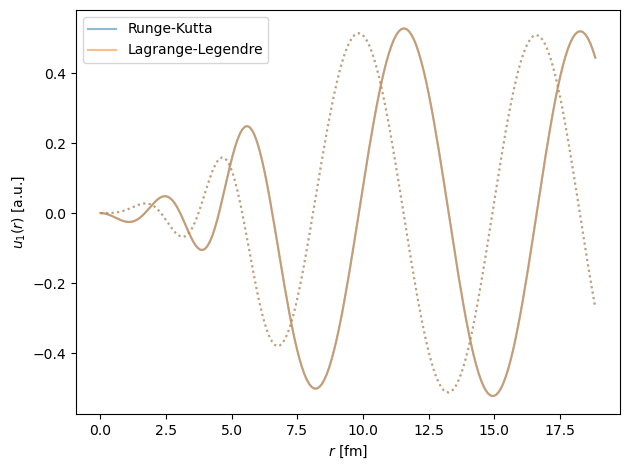

In [26]:
p = plt.plot(s_values, np.real(u_rk), alpha=0.5, label="Runge-Kutta")[0]
plt.plot(
    s_values,
    np.imag(u_rk),
    ":",
    color=p.get_color(),
    alpha=0.5,
)

p = plt.plot(s_values, np.real(u_lm), alpha=0.5, label="Lagrange-Legendre")[0]
plt.plot(
    s_values,
    np.imag(u_lm),
    ":",
    color=p.get_color(),
    alpha=0.5,
)

plt.legend()
plt.xlabel(r"$r$ [fm]")
plt.ylabel(r"$u_{%d} (r) $ [a.u.]" % ch.l)
plt.tight_layout()
plt.show()

Text(0, 0.5, '$|u^{RK} - u^{LM}| / |u^{RK}| (r) $ [%]')

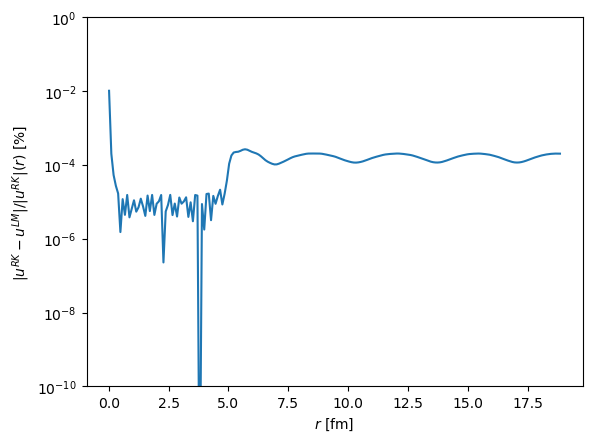

In [27]:
plt.semilogy(s_values, 100 * np.absolute(u_rk - u_lm) / (np.absolute(u_rk)))
plt.ylim([1e-10, 1])
plt.xlabel(r"$r$ [fm]")
plt.ylabel(r"$|u^{RK} - u^{LM}| / |u^{RK}| (r) $ [%]")